#From Linear classifiers to SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: Hamza ZBIRI
    

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#Modules for image processing
import skimage
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

#Modules for machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

#Useful for manual data splitting  
import random
from sklearn.utils import shuffle


# 1. Loading and splitting data

**a)** Download the animals10classes dataset from hippocampus, which is a subset of the Caltech 101 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). The animals subset is composed of images belonging to one among 10 classes. Run the code bellow to check images and labels are read correctly and store the name of the classes in the list ```labelNamesAll```

In [128]:
# Uncomment if using COLAB  (and comment next cell)
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = ('/content/drive/MyDrive/DATA/animals10classes')


In [2]:
# Uncomment if running locally (comment if running in COLAB)
IMDIR = 'Z:/animals10classes/'

In [3]:
#Keep4students
def loadImagesAndLabels(IMDIR):
  #This function glances through all subdirectories in IMDIR, 
  #and creates a list of the subdirectory names, which will be
  #used as labels for all the images within.The function returns
  #the list of labels
  #
  #If the function returns an empty list, it is likely that IMDIR
  #is not defined correctly. In that case uncomment the lines below
  #to check the files that are actually being read.

  labelNamesAll = []

  for root, dirnames, filenames in os.walk(IMDIR):
      labelNamesAll.append(dirnames)
      #uncomment to check if the folder contains images
#       for filename in filenames:
#         f = os.path.join(root, filename)
#         if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
#             print(f)
  
  labelNamesAll = labelNamesAll[0]
  return labelNamesAll

#Call the function and
#print the list of all labels/subdirectories

print (loadImagesAndLabels(IMDIR))

['ant', 'butterfly', 'crayfish', 'crocodile', 'dragonfly', 'flamingo', 'lobster', 'octopus', 'sea_horse', 'starfish', '__MACOSX']


**b).** Use the BuildDataset function to create a reduced dataset. In this notebook we will notably deal with binary classification problems. Print the sizes of the data matrix X and the label vector Y. Print as well the retained list of labels and the content of Y.

In [4]:
#Keep4students
def buildDataset (IMDIR,labelNamesAll,K=2,N=100,imHeight=100,imWidth=100,seed=50):
    #This function builds the data matrix from (a subset) of the label list.
    #Images are read using a composition of the path and the label list.
    #Parameters of this functions are:
    # K : the number of classes to consider
    # N : the maximum number of images to read from each category (the number 
    #    of images per label is variable). 
    # imHeight,imWidth: define the size of the target image. All read images
    #                  are resized to imHeight x imWidth
    # seed : fixes the random seed to be able to reproduce the results.
    # The function returns the data matrix X and the label vector Y.
    # Ideally, the X matrix will be of size (KxN)x(ImHeight x ImWidth) but 
    # the number of rows will be less if there number of images in a given
    # category is smaller than N

    X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
    Y = -np.ones([K*N,1]) #label indices initiallized to -1
    labelNames = [] #list of retained categories

    random.seed(a=seed) #comment to make each run random

    globalCount = 0 #counts the actual number of images copied to the datamatrix

    # Iterate over the number of classes
    for i in range(K): 
        #Randomly choose a new category
        while True:
            lab = random.randint(0,len(labelNamesAll)-1)
            if lab not in labelNames:
                break

        #define the path to read the images of the chosen label.
        #folders are named after the class label, print the chosen label
        filedir = os.path.join(IMDIR,labelNamesAll[lab])
        print('The chosen label ',i, ' is ',labelNamesAll[lab])
        print('It will be read in',filedir)

        #save the name of the class in labelNames
        labelNames.append(labelNamesAll[lab])       

        #walk through the files of the label folder,
        #read images in grayscale and resize them
        #flatten the images to a vector
        #copy each image to one row of the data matrix
        #use classCount to retain at most N images per class
        #use globalCount to keep track of the total number of images 
        classCount = 0
        for filename in os.listdir(filedir):
            f = os.path.join(filedir, filename)
            if f.endswith(('.jpg')) and (classCount < N):
                image = skimage.io.imread(f, as_gray=True)
                image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
                X[globalCount,:] = image.flatten()
                Y[globalCount,:] = i
                globalCount += 1
                classCount += 1

    #Remove the unused entries of X and Y
    print("Total number of samples",globalCount)
    X = X[:globalCount,:]
    Y = Y[:globalCount,:]

    return X,Y,labelNames

In [5]:
K=2
N = 50
imHeight=100
imWidth=100
labelNamesAll = loadImagesAndLabels(IMDIR)

seed = 47
#Call the buildDataset function

X,Y,labelNames = buildDataset (IMDIR,labelNamesAll,K,N,imHeight,imWidth,seed)

#Check the built dataset classes
print("Used labels",labelNames)
print("Size of data matrix", X.shape)
print("Class labels", Y.T)

The chosen label  0  is  flamingo
It will be read in Z:/animals10classes/flamingo
The chosen label  1  is  butterfly
It will be read in Z:/animals10classes/butterfly
Total number of samples 100
Used labels ['flamingo', 'butterfly']
Size of data matrix (100, 10000)
Class labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]]


**c)** Split the dataset into a train (80% of samples) and a test set (20% samples) subsets.

In [6]:
#PUT your code here, and check the obtained matrices
np.random.seed(seed)

nb_class0 = np.sum(Y==0)
n = nb_class0*80//100

indices = np.arange(nb_class0)
np.random.shuffle(indices)
indices_train = indices[:n]
indices_test = indices[n:]
Xtrain_class0 = X[indices_train,:]
Xtest_class0 = X[indices_test,:]

Ytrain_class0 = Y[indices_train]
Ytest_class0 = Y[indices_test]
 

nb_class1 = np.sum(Y==1)
n = nb_class1*80//100
indices = np.arange(nb_class0,nb_class0+nb_class1)
np.random.shuffle(indices)
indices_train = indices[:n]
indices_test = indices[n:]
Xtrain_class1 = X[indices_train,:]
Xtest_class1 = X[indices_test,:]

Ytrain_class1 = Y[indices_train]
Ytest_class1 = Y[indices_test]


X_train = np.concatenate((Xtrain_class0,Xtrain_class1),axis=0)
X_test = np.concatenate((Xtest_class0,Xtest_class1),axis=0)

Y_train = np.concatenate((Ytrain_class0,Ytrain_class1),axis=0)
Y_test = np.concatenate((Ytest_class0,Ytest_class1),axis=0)


print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)

print("train target vector",Y_train.T)
print("test target vector",Y_test.T)


size of train dataset (80, 10000)
size of test dataset (20, 10000)
train target vector [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]]
test target vector [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [7]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
B = np.array([[10,20,30],[40,50,60],[70,80,90]])
C = np.concatenate((A,B),axis=0)
print(A.shape)
print(C)

D = np.array([1,2,3,4,5])

(3, 3)
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 20 30]
 [40 50 60]
 [70 80 90]]


# 2. Support Vector Machines 

**a) Linear SVM** Create an SVC model with a linear kernel and default values ``svmLin=SVC(kernel='linear')``.
 
* Fit the SVC on the training dataset and make predictions on the test set. Is it necessary to normalize the features in this case?
* Print the vector of ground truth values and the vector of predictions.
* Compute  the number of errors made.
* Use the SVC.score() function. Which is the metric being computed?
* Activate the probability ``svmLin = SVC(kernel='linear',probability=True)``. 
* Make probabilistic predictions ``svmLin.predict_proba``
* How are these probabilities computed? (check the documentation)



In [8]:
# Create, train and test an svm model     
svmLin = SVC(kernel='linear')
Y_train = Y_train.ravel()
svmLin.fit(X_train,Y_train)

predictions = svmLin.predict(X_test)
print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int)) 
score = svmLin.score(X_test,Y_test)
print("le score donné par la méthode score de SVC est pour le même test: ",score)
print("le score donné correspond bien au ratio de bonnes prédictions sur le test set")

print("")
print("Modèle probabiliste")
print("")


# Create, train and test a "probabilistic" SVM model

svmLinp = SVC(kernel='linear',probability=True)
svmLinp.fit(X_train,Y_train)
predictionsp = svmLinp.predict_proba(X_test)
#print(predictionsp)
predictionsp = predictionsp[:,0] - predictionsp[:,1]
predictionsp = np.array(predictionsp<0,dtype=float)
print("vrais labels                                 ",Y_test.T[0])
print("labels predits par le modele non probabiliste",predictions)
print("labels predits par le modele probabiliste    ",predictionsp)

print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictionsp-Y_test.T)),dtype=int)) 
scorep = svmLinp.score(X_test,Y_test)
print("le score donné par la méthode score de SVC probabiliste est pour le même test: ",scorep,"\n")
print("cest pas normal que le score donné par la méthode soit le meme dans les deux cas alors que l'on compte bien un nombre d'erreurs différents a la main")

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
le score donné correspond bien au ratio de bonnes prédictions sur le test set

Modèle probabiliste

vrais labels                                  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
labels predits par le modele non probabiliste [0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
labels predits par le modele probabiliste     [0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1.]
le nombre d'erreurs sur le test set de taille 20 est:  8
le score donné par la méthode score de SVC probabiliste est pour le même test:  0.65 

cest pas normal que le score donné par la méthode soit le meme dans les deux cas alors que l'on compte bien un nombre d'erreurs différents a la main


**b) Support vectors**
* How many parameters does the **model** have? (Hint: the answer is not SVC.get_params())
* How many hyperparameters?
* How many support vectors?
* Display some of the support vectors. Hint: use ``plt.imshow``



[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 16 17 18 19 21 23 24 26 27 28
 29 30 31 32 33 35 36 37 38 39 40 42 43 44 46 47 48 49 50 51 52 53 54 55
 56 59 60 62 63 64 65 66 67 68 69 70 71 73 74 75 76 77 78 79]
[[-0.00592618 -0.00207224 -0.00071852 -0.0065271  -0.00403038 -0.03384454
  -0.00297084 -0.00397643 -0.00166013 -0.00379086 -0.01134595 -0.00099585
  -0.00835773 -0.00437294 -0.0035579  -0.01877109 -0.00894401 -0.00019838
  -0.00427255 -0.00188374 -0.00237884 -0.00474253 -0.00201255 -0.00124404
  -0.00355912 -0.00426233 -0.01028196 -0.00736382 -0.00367973 -0.0532775
  -0.00208432 -0.00298538 -0.00341227 -0.00702457  0.00738561  0.00350693
   0.00305353  0.00476346  0.00641274  0.00523651  0.00104148  0.01507376
   0.03186421  0.00770052  0.00218774  0.0088998   0.00149373  0.0064853
   0.00145666  0.00119741  0.00086587  0.0075178   0.00574849  0.00328132
   0.00670452  0.00130653  0.00400981  0.0100896   0.01001168  0.00110597
   0.01249301  0.02211622  0.00322996  0.00215639  0.0

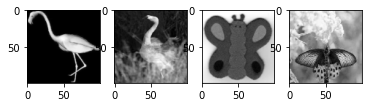

In [9]:
print((svmLin.support_)) 
print((svmLin.dual_coef_)) #coefficients alpha

indices = [5,37,53,71]

for i in range(4):
    im = X[indices[i],:]
    im = im.reshape(imHeight,imWidth)
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')

plt.show()

**c) Kernel SVMs.**
* Train three additional SVC models each using one among the kernel functions:
```
'kernel': ['rbf','poly', 'sigmoid'],
```
keep all other parameters to their default value.
* Report the number of support vectors found after fitting
* What are the hyperparameters available in each case? 
* Report the number of errors and the accuracy for each model

In [10]:
svmLin = SVC(kernel='rbf')
Y_train = Y_train.ravel()
svmLin.fit(X_train,Y_train)

predictions = svmLin.predict(X_test)
print('kernel rbf')

print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int)) 
score = svmLin.score(X_test,Y_test)
print(len(svmLin.support_)," vecteurs")
print("le score donné par la méthode score de SVC est pour le même test: ",score)
print("le score donné correspond bien au ratio de bonnes prédictions sur le test set")
print('')

svmLin = SVC(kernel='poly')
Y_train = Y_train.ravel()
svmLin.fit(X_train,Y_train)

predictions = svmLin.predict(X_test)
print('kernel poly')
print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int))

score = svmLin.score(X_test,Y_test)
print(len(svmLin.support_)," vecteurs")
print("le score donné par la méthode score de SVC est pour le même test: ",score)
print("le score donné correspond bien au ratio de bonnes prédictions sur le test set")
print('')


svmLin = SVC(kernel='sigmoid')
Y_train = Y_train.ravel()
svmLin.fit(X_train,Y_train)

predictions = svmLin.predict(X_test)
print('kernel sigmoid')
print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int)) 
score = svmLin.score(X_test,Y_test)
print(len(svmLin.support_)," vecteurs")
print("le score donné par la méthode score de SVC est pour le même test: ",score)
print("le score donné correspond bien au ratio de bonnes prédictions sur le test set")
print('')

kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  6
75  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.7
le score donné correspond bien au ratio de bonnes prédictions sur le test set

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  6
64  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.7
le score donné correspond bien au ratio de bonnes prédictions sur le test set

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  10
70  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5
le score donné correspond bien au ratio de bonnes prédictions sur le test set



**d)Hyperparameter tuning** 
Tune the hyperparameters of both the linear and the non-linear SVMs using the validation set. Alternatively use the ``GridSearchCV`` functionality from sklearn

In [18]:
# Some values for reference, you might change this for improved results
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001], 
              'degree': [2, 3, 5]}


for C0 in param_grid['C']:
    for gamma0 in param_grid['gamma']:
        for degree0 in param_grid['degree']:
            print('C = ',C0,'gamma = ',gamma0,'degree = ',degree0)
            print('')
            svmLin = SVC(kernel='linear',C=C0,gamma=gamma0,degree=degree0)
            Y_train = Y_train.ravel()
            svmLin.fit(X_train,Y_train)
            predictions = svmLin.predict(X_test)
            print('linéaire')
            print('')
            print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int)) 
            score = svmLin.score(X_test,Y_test)
            print("le score donné par la méthode score de SVC est pour le même test: ",score)
            svmLin = SVC(kernel='rbf',C=C0,gamma=gamma0,degree=degree0)
            Y_train = Y_train.ravel()
            svmLin.fit(X_train,Y_train)

            predictions = svmLin.predict(X_test)
            print('kernel rbf')

            print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int)) 
            score = svmLin.score(X_test,Y_test)
            print(len(svmLin.support_)," vecteurs")
            print("le score donné par la méthode score de SVC est pour le même test: ",score)
            
            print('')

            svmLin = SVC(kernel='poly',C=C0,gamma=gamma0,degree=degree0)
            Y_train = Y_train.ravel()
            svmLin.fit(X_train,Y_train)

            predictions = svmLin.predict(X_test)
            print('kernel poly')
            print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int))

            score = svmLin.score(X_test,Y_test)
            print(len(svmLin.support_)," vecteurs")
            print("le score donné par la méthode score de SVC est pour le même test: ",score)
            
            print('')


            svmLin = SVC(kernel='sigmoid',C=C0,gamma=gamma0,degree=degree0)
            Y_train = Y_train.ravel()
            svmLin.fit(X_train,Y_train)

            predictions = svmLin.predict(X_test)
            print('kernel sigmoid')
            print("le nombre d'erreurs sur le test set de taille 20 est: ",np.sum((np.abs(predictions-Y_test.T)),dtype=int)) 
            score = svmLin.score(X_test,Y_test)
            print(len(svmLin.support_)," vecteurs")
            print("le score donné par la méthode score de SVC est pour le même test: ",score)
        
            print('')



C =  0.1 gamma =  1 degree =  2

linéaire

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  5
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.75

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  6
66  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.7

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  10
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5

C =  0.1 gamma =  1 degree =  3

linéaire

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  5
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.75

kernel poly
le nombre d'erreurs sur 

linéaire

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  10
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  6
66  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.7

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  10
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5

C =  1 gamma =  0.1 degree =  3

linéaire

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  10
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  5


kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  4
50  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.8

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  10
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5

C =  10 gamma =  0.01 degree =  2

linéaire

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  9
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.55

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  6
66  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.7

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  10
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.5

C =  10 gamma =  0.01 degree =  3

linéaire

le 

80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.55

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  6
66  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.7

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  11
76  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.45

C =  100 gamma =  0.01 degree =  3

linéaire

le nombre d'erreurs sur le test set de taille 20 est:  7
le score donné par la méthode score de SVC est pour le même test:  0.65
kernel rbf
le nombre d'erreurs sur le test set de taille 20 est:  9
80  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.55

kernel poly
le nombre d'erreurs sur le test set de taille 20 est:  5
59  vecteurs
le score donné par la méthode score de SVC est pour le même test:  0.75

kernel sigmoid
le nombre d'erreurs sur le test set de taille 20 est:  11
76  vecteurs
le score donné par la méthode s

## 3. PERFORMANCE MEASURES
**a) Fill in the function bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN

You can use the code bellow or use your own

**Hint:** Add a numerical zero eps to the denominators to prevent dividing by zero

Compare your results vs the in-built sklearn measures:
```from sklearn.metrics import classification_report```

In [228]:
# Functions to compute the errors between prediction and ground truth 



def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)
    
    eps = 1e-12
      
    
    # True positives TP
    TP = np.sum(np.array((Y_pred==positiveClass)and(Y_gt==positiveClass)),dtype=int)
        
    # True negatives TN
    TN = np.sum(np.array((Y_pred!=positiveClass)and(Y_gt!=positiveClass)),dtype=int)
    
    # False positives FP
    FP = np.sum(np.array((Y_pred==positiveClass)and(Y_gt!=positiveClass)),dtype=int)
        
    # False negatives FN
    FN = np.sum(np.array((Y_pred!=positiveClass)and(Y_gt==positiveClass)),dtype=int)

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN

    
    # Accuracy
    measures['accuracy'] = (TP+TN)/(TP+TN+FP+FN)
    
    # Precision
    measures['precision'] = TP/(TP+FP)
        
    # Specificity
    measures['specificity']= TN/(TN+FP)
    
    # Recall
    measures['recall'] = TP(TP+FP)
    
    # F-measure
    measures['f1'] = 2*TP/(2*TP+FP+FN)
    
    # Negative Predictive Value
    measures['npv'] = TP/(TP+FP)
    
    # False Predictive Value
    measures['fpr'] = TN/(TN+FN)
    
    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')
    
    return measures




**b) ROC curves** 
- Plot the ROC curves of all the trained svm models (with different kernels including linear) before and after the hyperparameter tuning. Comment the results
- Compare the roc curves of the best obtained models for each kernel between. Also add a curve for a  logistic regression model. 

You might use your own thresholding function or use the ``roc_curve`` functionality from scikit learn

Hint: To threshold we need to make probabilistic predictions

In [38]:
# Logistic Regression

svmLin = SVC(kernel='sigmoid',C=100,gamma=0.001,degree=degree0,probability=True)
Y_train = Y_train.ravel()
svmLin.fit(X_train,Y_train)

Y_pred_logreg_probas = svmLin.predict(X_test)
print(Y_pred_logreg_probas)

[1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.]


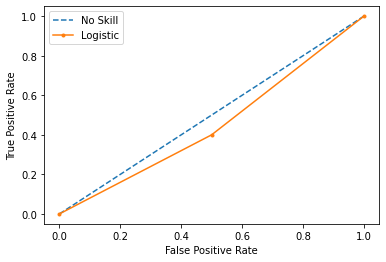

In [39]:
# plot no skill roc curve
 
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate roc curve for logistic regression
fpr, tpr, _ = roc_curve(Y_test, Y_pred_logreg_probas)
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()



**c) Qualitative Results** Using your best model, show some of the test images and write on the title the predictions vs the ground truth labels 

In [ ]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

#Change your predictions vector here
Y_best=Y_rbfBest

fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth)) 

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_best.ravel()[i].astype(int)] 
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()
